In [1]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from scipy.spatial import cKDTree
from astropy.table import Table
from pyia import GaiaData
import gala.coordinates as gc

In [2]:
gals = ascii.read('/Users/adrian/data/Misc/NearbyGalaxies.dat')
gals_c = coord.SkyCoord(ra=gals['RA'], dec=gals['Dec'], unit=(u.hourangle, u.degree),
                        distance=coord.Distance(distmod=gals['distmod']))
# gals = gals[gals_c.distance < 50*u.kpc]
# gals_c = gals_c[gals_c.distance < 50*u.kpc]
len(gals_c)

110

In [3]:
glob = Table.read('/Users/adrian/data/Misc/harris-gc-catalog.fits')
glob_c = coord.SkyCoord(ra=glob['RA'].data*u.deg, dec=glob['DEC'].data*u.deg, 
                        distance=glob['HELIO_DISTANCE'].data*u.kpc)
# mask = (np.abs(glob_c.galactic.b) > 15*u.deg)
# glob = glob[mask]
# glob_c = glob_c[mask]
len(glob_c)

157

In [4]:
allrrl = Table.read('/Users/adrian/data/GaiaDR2/rrlyrae.fits')
rrl = allrrl[allrrl['parallax'] < 0.5]
bhb = Table.read('/Users/adrian/data/GaiaDR2/blue_distant.fits')

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [5]:
len(rrl), len(bhb)

(126733, 2524361)

### First look at the absolute G magnitude of RRL's:

In [6]:
g_allrrl = GaiaData(allrrl)

In [7]:
close_rrl_mask = ((g_allrrl.parallax/g_allrrl.parallax_error) > 10) & (g_allrrl.parallax > 1*u.mas)
g_close = g_allrrl[close_rrl_mask]
len(g_close)

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


133

(5, -2)

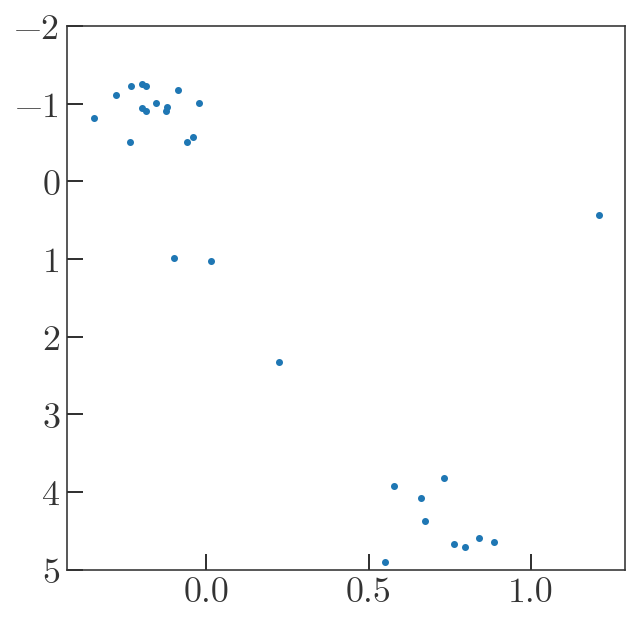

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(g_close.int_average_bp-g_close.int_average_rp- g_close.e_bp_min_rp_val, 
           g_close.int_average_g - g_close.distmod - g_close.a_g_val, 
           marker='.')
ax.set_ylim(5, -2)

In [9]:
grrl = GaiaData(rrl)
gbhb = GaiaData(bhb)

crrl = coord.SkyCoord(ra=grrl.ra, dec=grrl.dec,
                      distance=coord.Distance(distmod=grrl.int_average_g - -1*u.mag),
                      pm_ra_cosdec=grrl.pmra, 
                      pm_dec=grrl.pmdec)
cbhb = coord.SkyCoord(ra=gbhb.ra, dec=gbhb.dec,
                      distance=coord.Distance(distmod=gbhb.phot_g_mean_mag - -1*u.mag),
                      pm_ra_cosdec=gbhb.pmra, 
                      pm_dec=gbhb.pmdec)

(20.5, 6)

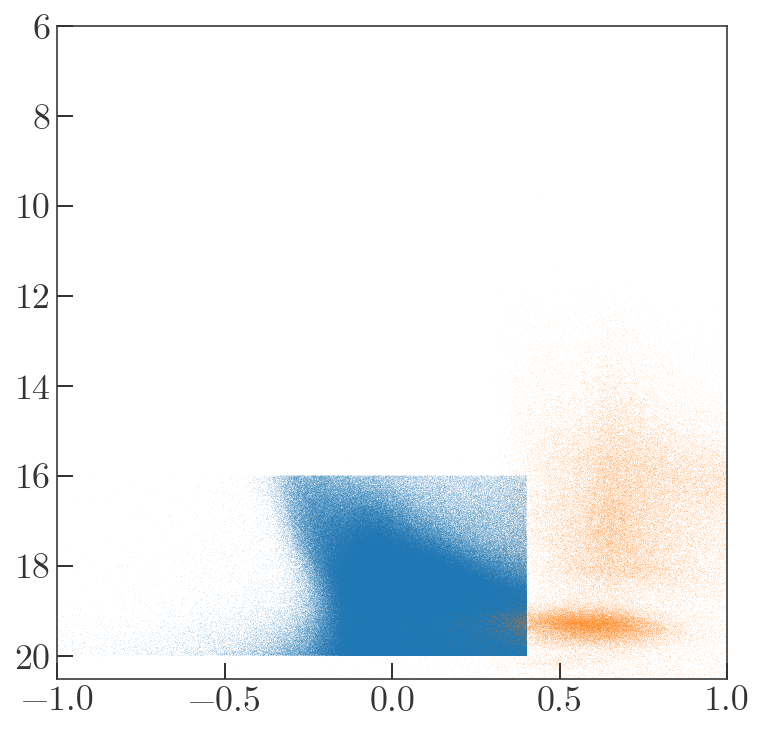

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(gbhb.phot_bp_mean_mag - gbhb.phot_rp_mean_mag, 
        gbhb.phot_g_mean_mag, marker=',', linestyle='none', alpha=0.1)
ax.plot(grrl.phot_bp_mean_mag - grrl.phot_rp_mean_mag, 
        grrl.phot_g_mean_mag, marker=',', linestyle='none', alpha=0.1)
ax.set_xlim(-1, 1.)
ax.set_ylim(20.5, 6)

In [11]:
all_c = coord.concatenate((crrl, cbhb))
len(all_c)

2651094

In [12]:
mag_c = all_c.transform_to(gc.MagellanicStream)
mag_mask = np.logical_not((mag_c.L.wrap_at(180*u.deg) < 10*u.deg) & 
                          (mag_c.L.wrap_at(180*u.deg) > -20*u.deg) & 
                          (mag_c.B < 15*u.deg) & (mag_c.B > -20*u.deg))

# Some other cuts too!
mag_mask_rrl = mag_mask[:len(crrl)] & (crrl.distance > 10*u.kpc) & (crrl.distance < 100*u.kpc)
mag_mask_bhb = mag_mask[len(crrl):] & (cbhb.distance > 10*u.kpc) & (cbhb.distance < 100*u.kpc)

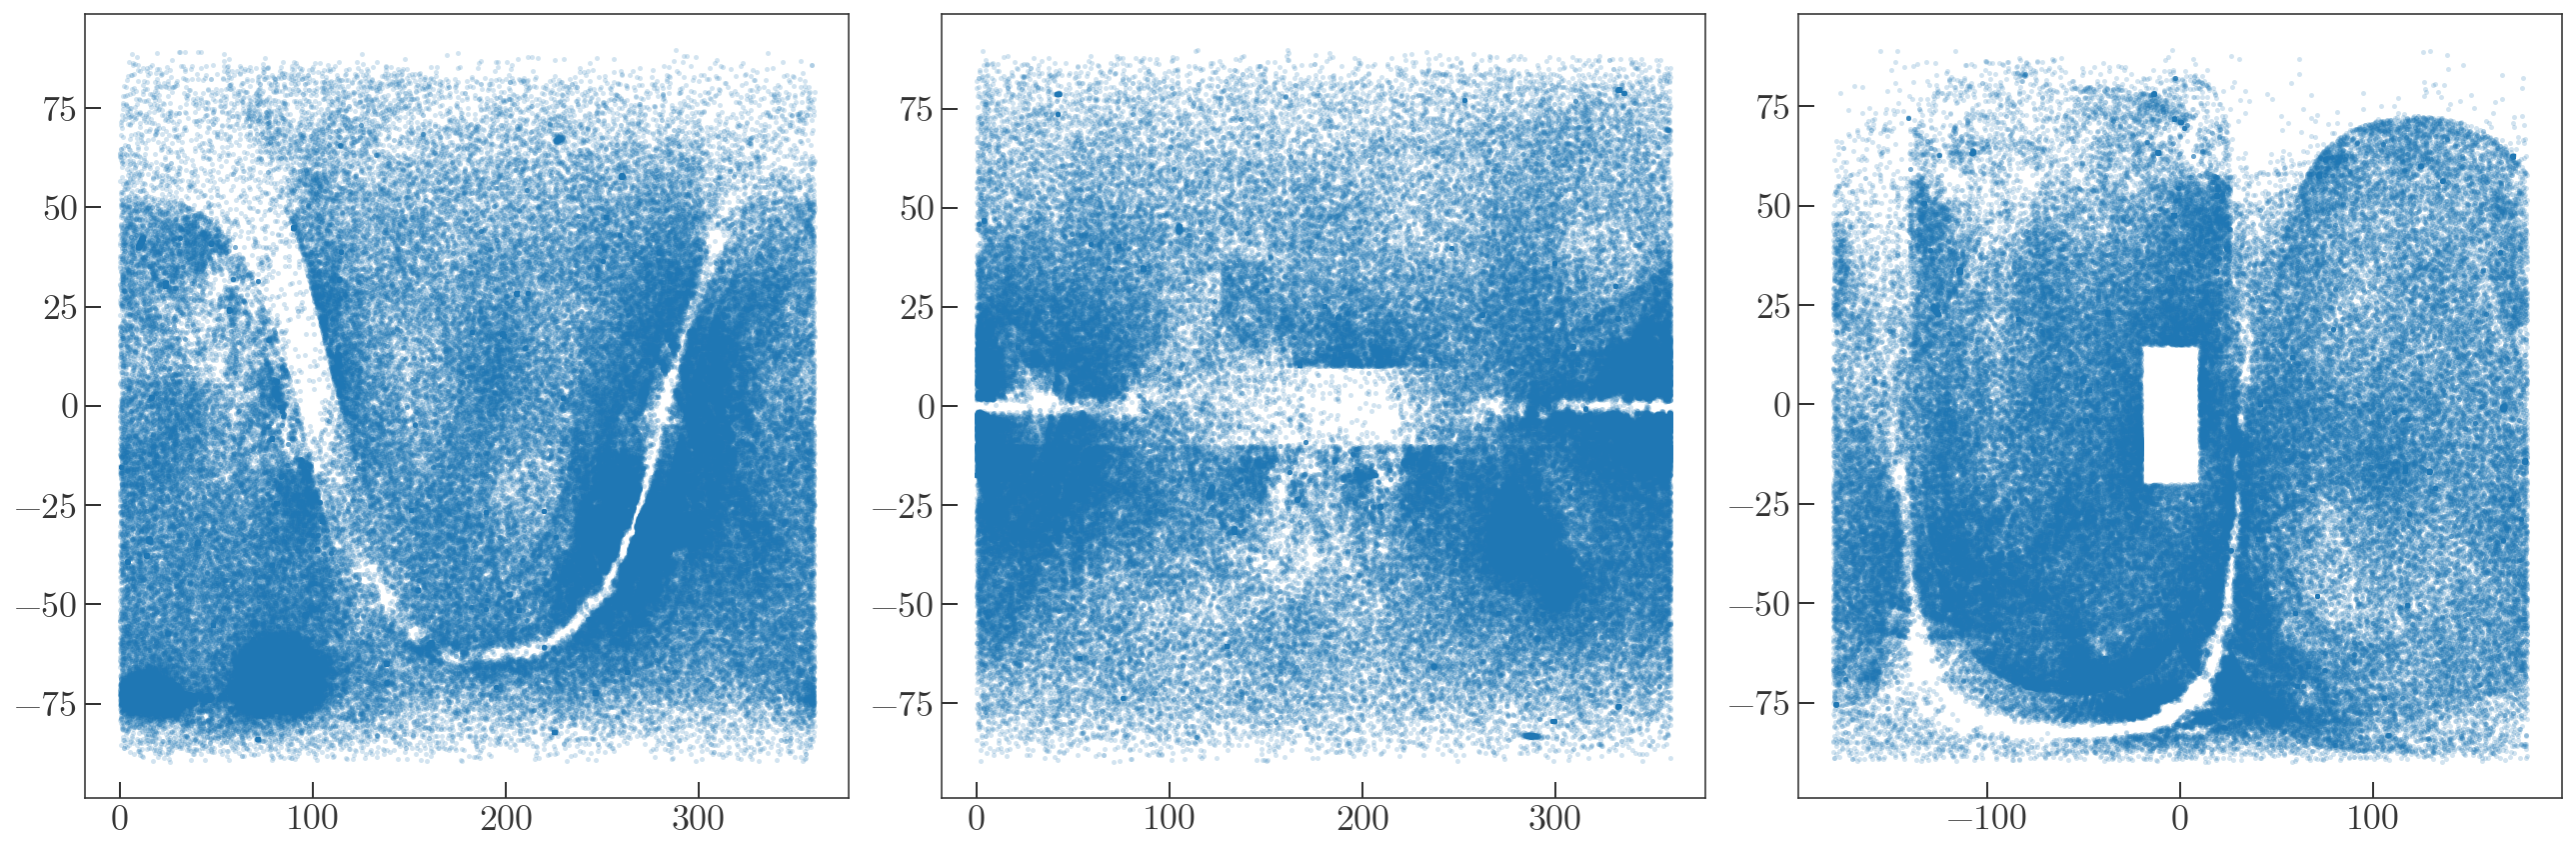

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].plot(all_c.ra.degree, all_c.dec.degree, marker='.', linestyle='none', alpha=0.2)
axes[1].plot(all_c.galactic.l.degree, all_c.galactic.b.degree, marker='.', linestyle='none', alpha=0.2)
axes[2].plot(mag_c.L.wrap_at(180*u.deg).degree[mag_mask], 
             mag_c.B.degree[mag_mask], 
             marker='.', linestyle='none', alpha=0.2)
fig.tight_layout()

In [14]:
mag_mask.sum()

180335

In [15]:
crrl_mask = crrl[mag_mask_rrl]
cbhb_mask = cbhb[mag_mask_bhb]

---

In [16]:
c1 = crrl_mask
# c2 = cbhb_mask
c2 = crrl_mask

In [17]:
idx1, idx2, sep, _ = coord.search_around_sky(c1, c2, seplimit=0.5*u.deg)

In [18]:
dpm = np.sqrt((c1[idx1].pm_ra_cosdec - c2[idx2].pm_ra_cosdec)**2 + 
              (c1[idx1].pm_dec - c2[idx2].pm_dec)**2)

In [19]:
# pm_h = (10*u.km/u.s / (c[idx1].distance)).to(u.mas/u.yr, u.dimensionless_angles())
pm_h = 0.1*u.mas/u.yr

In [20]:
pm_mask = (dpm < pm_h) & (dpm > 0*u.mas/u.yr)
pm_mask.sum()

4288

In [21]:
pm_idx1 = idx1[pm_mask]
pm_idx2 = idx2[pm_mask]

In [22]:
N_gtr_3 = 0
mean_c = []
all_idx = []
for i1 in np.unique(pm_idx1):
    i2s = pm_idx2[pm_idx1 == i1]
    
    if len(i2s) < 2:
        continue
        
    N_gtr_3 += 1
    
    mean_c.append([np.mean(c2[i2s].ra.degree),
                   np.mean(c2[i2s].dec.degree),
                   np.mean(c2[i2s].pm_ra_cosdec.value),
                   np.mean(c2[i2s].pm_dec.value)])
    all_idx.append(i2s)
    
mean_c = np.array(mean_c)
mean_c = coord.SkyCoord(ra=mean_c[:,0]*u.deg, dec=mean_c[:,1]*u.deg,
                        pm_ra_cosdec=mean_c[:,2]*u.mas/u.yr,
                        pm_dec=mean_c[:,3]*u.mas/u.yr,)
all_idx = np.array(all_idx)

Text(0,0.5,'$b$ [deg]')

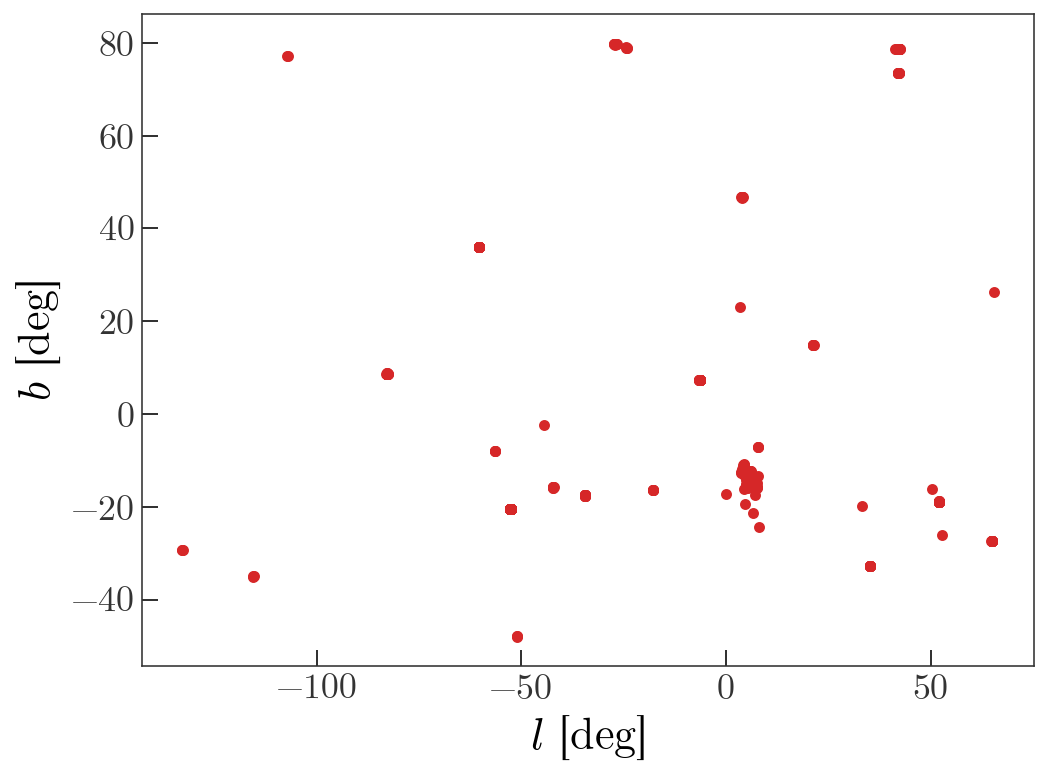

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(mean_c.galactic.l.wrap_at(180*u.deg), 
           mean_c.galactic.b, 
           s=20, color='tab:red')

ax.set_xlabel('$l$ [deg]')
ax.set_ylabel('$b$ [deg]')

In [24]:
idx, sep, _ = mean_c.match_to_catalog_sky(glob_c)
unknown_mask = sep > 0.5*u.deg

idx, sep, _ = mean_c.match_to_catalog_sky(gals_c)
unknown_mask &= sep > 0.5*u.deg

unknown_mask &= np.abs(mean_c.galactic.l.wrap_at(180*u.deg)) > 10*u.deg

unknown_mask.sum()

8

Text(0,0.5,'$b$ [deg]')

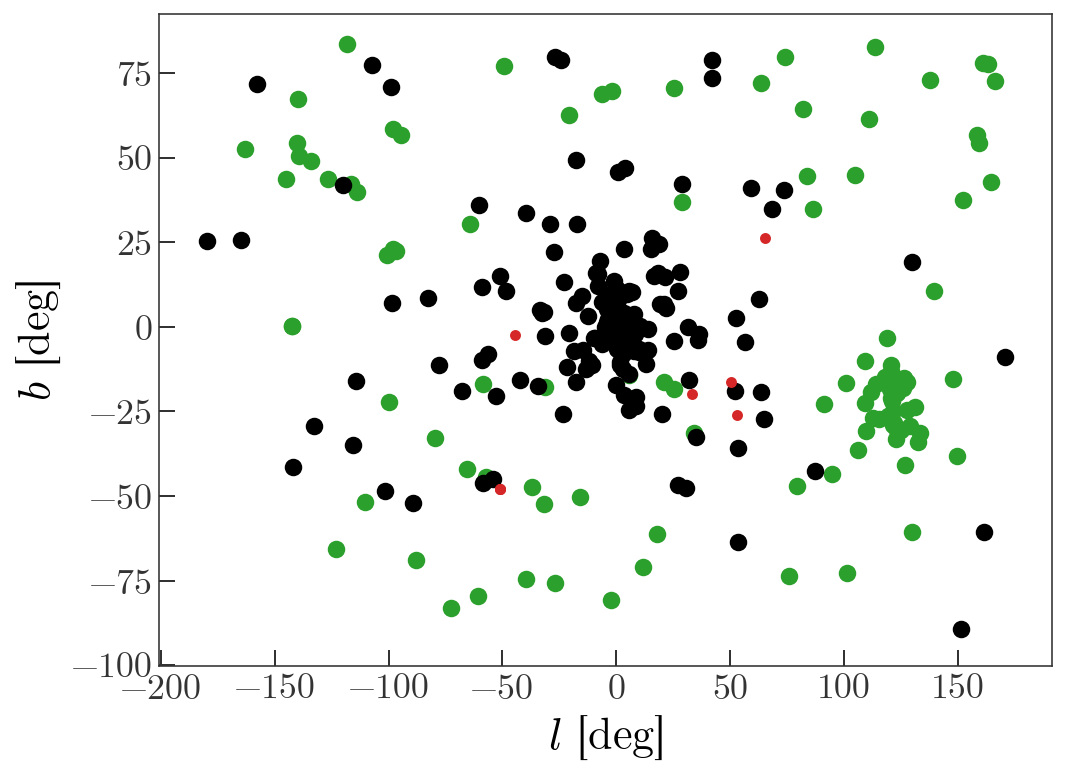

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(gals_c.galactic.l.wrap_at(180*u.deg),
           gals_c.galactic.b, marker='o', s=60, color='tab:green', zorder=-10)

ax.scatter(glob_c.galactic.l.wrap_at(180*u.deg),
           glob_c.galactic.b, marker='o', s=60, color='k', zorder=-10)

ax.scatter(mean_c.galactic.l.wrap_at(180*u.deg)[unknown_mask], 
           mean_c.galactic.b[unknown_mask], 
           s=20, color='tab:red')

ax.set_xlabel('$l$ [deg]')
ax.set_ylabel('$b$ [deg]')

In [26]:
q_fmt = """SELECT source_id, ra, dec, pmra, pmdec, phot_g_mean_mag, bp_rp
FROM gaiadr2.gaia_source
WHERE parallax < 1 AND bp_rp > -1 AND bp_rp < 2.5 AND
      CONTAINS(POINT('ICRS', ra, dec), 
               CIRCLE('ICRS', {0.ra.degree}, {0.dec.degree}, {1.degree}))=1 AND
      (pmra > -15) AND (pmra < 15) AND 
      (pmdec > -15) AND (pmdec < 15)"""

In [8]:
for unk_c in mean_c[unknown_mask][4:]:
    q = q_fmt.format(unk_c, coord.Angle(2*u.deg))
    
    dpm = np.sqrt((c1.pm_ra_cosdec - unk_c.pm_ra_cosdec)**2 + 
                  (c1.pm_dec - unk_c.pm_dec)**2)
    
    row_c = c1[ (c1.separation(unk_c) < 0.5*u.deg) & (dpm < pm_h) ]
    print(np.mean(row_c.ra.degree), np.mean(row_c.dec.degree))
    print(mean_pmra, mean_pmdec)
    mean_pmra = np.mean(row_c.pm_ra_cosdec)
    mean_pmdec = np.mean(row_c.pm_dec)
    
    break

NameError: name 'mean_c' is not defined

In [77]:
blob_g = GaiaData.from_query(q)
blob_c = blob_g.get_skycoord(distance=False)

Launched query: 'SELECT source_id, ra, dec, pmra, pmdec, phot_g_mean_mag, bp_rp
FROM gaiadr2.gaia_source
WHERE parallax < 1 AND bp_rp > -1 AND bp_rp < 2.5 AND
      CONTAINS(POINT('ICRS', ra, dec), 
               CIRCLE('ICRS', 269.95898392860033, 39.10071300738002, 2.0))=1 AND
      (pmra > -15) AND (pmra < 15) AND 
      (pmdec > -15) AND (pmdec < 15)'
Retrieving async. results...


Query finished.


(-15, 15)

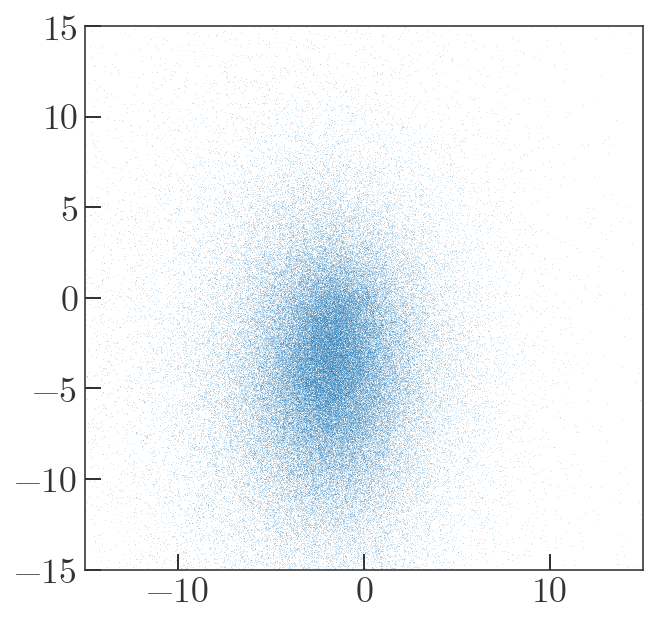

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(blob_g.data['pmra'], blob_g.data['pmdec'], 
        marker=',', linestyle='none', alpha=0.2)

# ax.scatter(mean_pmra, mean_pmdec, color='tab:orange', zorder=10)

ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)

(21, 10)

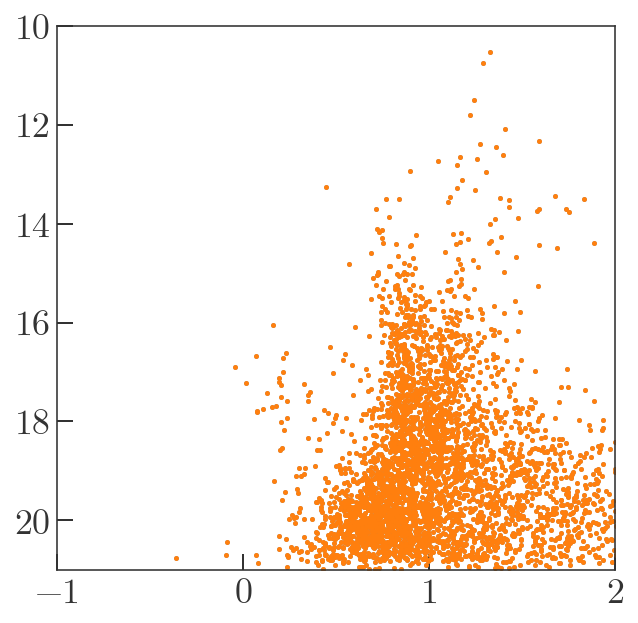

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

unk_pm_mask = np.sqrt((blob_g.data['pmra'] - mean_pmra.value)**2 + 
                      (blob_g.data['pmdec'] - mean_pmdec.value)**2) < 1
# unk_cmd_mask = np.sqrt((blob_g.data['bp_rp'] - 1.)**2 + 
#                        (blob_g.data['phot_g_mean_mag']-19.2)**2) < 0.25
unk_cmd_mask = np.ones_like(unk_pm_mask)

ax.plot(blob_g.data['bp_rp'][unk_pm_mask], 
        blob_g.data['phot_g_mean_mag'][unk_pm_mask], 
        marker='.', linestyle='none', alpha=0.5)

ax.plot(blob_g.data['bp_rp'][unk_pm_mask & unk_cmd_mask], 
        blob_g.data['phot_g_mean_mag'][unk_pm_mask & unk_cmd_mask], 
        marker='.', linestyle='none', alpha=1)

ax.set_xlim(-1, 2)
ax.set_ylim(21, 10)

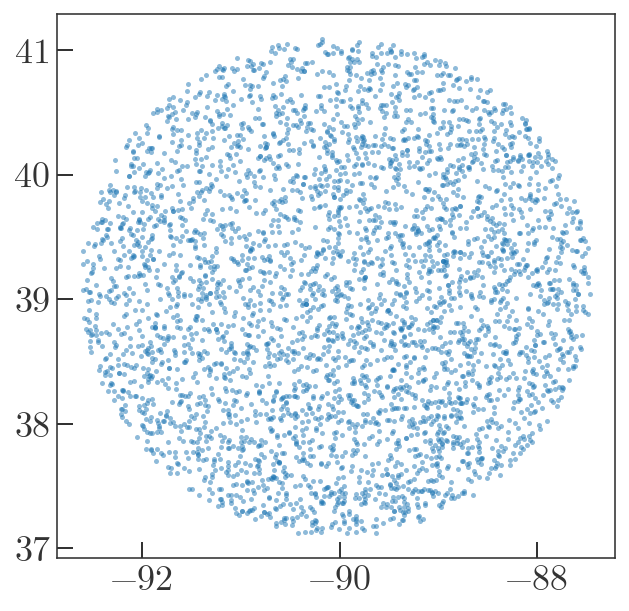

In [82]:
fuck = coord.Angle(blob_g.data['ra'][unk_pm_mask & unk_cmd_mask])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(fuck.wrap_at(180*u.deg).degree, 
        blob_g.data['dec'][unk_pm_mask & unk_cmd_mask], 
        marker='.', linestyle='none', alpha=0.5)

Note: worth following up! (get better photometry!)

315.081785578 4.20305369622
-0.12385492612083628 mas / yr -1.5908598064646677 mas / yr

269.864017023 39.0097565232
0.7523414870376065 mas / yr -1.2723585025752302 mas / yr